In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import scipy.stats as stats
import time
import random

In [2]:
# Set the random seed for reproducibility
def set_random_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    np.random.seed(seed)
    random.seed(seed)
    return seed

# Load the provided raw data files
external_data_path = 'data/ExternalData.csv'
stock_data_path = 'data/StockData.csv'

external_data = pd.read_csv(external_data_path)
stock_data = pd.read_csv(stock_data_path)

In [3]:
# Clean external data by dropping unnecessary columns and formatting numeric data
external_data_cleaned = external_data.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])
external_data_cleaned['Billions of US $'] = external_data_cleaned['Billions of US $'].replace({',': ''}, regex=True).astype(float)

# Handle NaN values in the Year column
external_data_cleaned = external_data_cleaned.dropna(subset=['Year'])
external_data_cleaned['Year'] = external_data_cleaned['Year'].str.replace(',', '').astype(int)

# Extract the year from the Date column in stock data
stock_data['Year'] = pd.to_datetime(stock_data['Date']).dt.year

# Merge the external data with the stock data on the Year column
merged_data = pd.merge(stock_data, external_data_cleaned, on='Year', how='left')

# Clean the NIFTY column by removing commas and converting to numeric
merged_data['NIFTY'] = merged_data['NIFTY'].replace({',': ''}, regex=True).astype(float)

# Normalize the data
columns_to_normalize = merged_data.columns.difference(['Date', 'Year'])
scaler = MinMaxScaler()
merged_data[columns_to_normalize] = scaler.fit_transform(merged_data[columns_to_normalize])

# Explicitly list and extract each unique stock column
stock_columns_list = ['AAPL', 'AMZN', 'BA', 'CVX', 'F', 'GS', 'JNJ', 'JPM', 'MSFT', 'PFE', 'PG', 'TGT', 'TM', 'WMT', 'XOM']
stock_data_corrected = merged_data[stock_columns_list].copy()

In [4]:
# Define the fitness function (Sharpe ratio)
def fitness_function(weights, stock_data):
    portfolio_return = np.sum(stock_data.mean() * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_data.cov(), weights)))
    return portfolio_return / portfolio_risk

# Calculate additional performance metrics
def calculate_additional_metrics(weights, stock_data):
    portfolio_return = np.sum(stock_data.mean() * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_data.cov(), weights)))
    sharpe_ratio = portfolio_return / portfolio_risk

    annualized_return = ((1 + portfolio_return) ** 252) - 1
    annualized_risk = portfolio_risk * np.sqrt(252)
    stability = portfolio_risk / portfolio_return

    return {
        'Weights': weights,
        'Return': portfolio_return,
        'Risk': portfolio_risk,
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Risk': annualized_risk,
        'Stability': stability
    }

# Genetic Programming (GP)
def genetic_programming(stock_data, num_assets, num_generations, pop_size, crossover_prob, mutation_prob, tournament_size):
    total_function_evaluations = 0
    total_operations = 0
    
    def initialize_population(pop_size, num_assets):
        return np.random.dirichlet(np.ones(num_assets), size=pop_size)

    def tournament_selection(population, fitnesses, k=3):
        selected = []
        for _ in range(len(population)):
            aspirants = np.random.choice(len(population), k)
            selected.append(population[np.argmax(fitnesses[aspirants])])
        return np.array(selected)

    def blend_crossover(parent1, parent2, alpha=0.5):
        gamma = np.random.uniform(-alpha, 1 + alpha, size=len(parent1))
        child1 = gamma * parent1 + (1 - gamma) * parent2
        child2 = gamma * parent2 + (1 - gamma) * parent1
        return child1, child2

    def mutate(individual, mu=0, sigma=0.1, mutation_prob=0.2):
        if np.random.rand() < mutation_prob:
            mutation = np.random.normal(mu, sigma, size=len(individual))
            individual = np.clip(individual + mutation, 0, 1)
            individual = individual / np.sum(individual)  # Ensure sum of weights is 1
        return individual

    def evaluate_population(population, stock_data):
        fitnesses = []
        for ind in population:
            fitness = fitness_function(ind, stock_data)
            fitnesses.append(fitness)
            nonlocal total_function_evaluations, total_operations
            total_function_evaluations += 1
            total_operations += 2 * len(ind)  # Simple operation count for demonstration
        return np.array(fitnesses)

    population = initialize_population(pop_size, num_assets)
    for gen in range(num_generations):
        fitnesses = evaluate_population(population, stock_data)
        selected_population = tournament_selection(population, fitnesses, k=tournament_size)
        offspring = []
        for i in range(0, len(selected_population), 2):
            if np.random.rand() < crossover_prob:
                child1, child2 = blend_crossover(selected_population[i], selected_population[i+1])
                offspring.append(child1)
                offspring.append(child2)
            else:
                offspring.append(selected_population[i])
                offspring.append(selected_population[i+1])
        population = np.array([mutate(ind, mutation_prob=mutation_prob) for ind in offspring])

    fitnesses = evaluate_population(population, stock_data)
    best_individual_idx = np.argmax(fitnesses)
    best_individual = population[best_individual_idx]
    return best_individual, fitnesses[best_individual_idx], total_function_evaluations, total_operations

# Differential Evolution (DE)
def differential_evolution(stock_data, num_assets, num_generations, pop_size, F, CR):
    total_function_evaluations = 0
    total_operations = 0
    
    population = np.random.dirichlet(np.ones(num_assets), size=pop_size)
    fitnesses = np.array([fitness_function(ind, stock_data) for ind in population])
    total_function_evaluations += pop_size
    total_operations += 2 * num_assets * pop_size
    
    for gen in range(num_generations):
        for i in range(pop_size):
            indices = list(range(pop_size))
            indices.remove(i)
            a, b, c = population[np.random.choice(indices, 3, replace=False)]
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(num_assets) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, num_assets)] = True
            trial = np.where(cross_points, mutant, population[i])
            trial /= np.sum(trial)  # Ensure sum of weights is 1
            trial_fitness = fitness_function(trial, stock_data)
            total_function_evaluations += 1
            total_operations += 2 * num_assets
            
            if trial_fitness > fitnesses[i]:
                population[i] = trial
                fitnesses[i] = trial_fitness
    
    best_idx = np.argmax(fitnesses)
    return population[best_idx], fitnesses[best_idx], total_function_evaluations, total_operations

# Harmony Search (HS)
def harmony_search(stock_data, num_assets, num_iterations, pop_size, hmcr, par, bw):
    total_function_evaluations = 0
    total_operations = 0
    
    harmony_memory = np.random.dirichlet(np.ones(num_assets), size=pop_size)
    fitnesses = np.array([fitness_function(ind, stock_data) for ind in harmony_memory])
    total_function_evaluations += pop_size
    total_operations += 2 * num_assets * pop_size
    
    for _ in range(num_iterations):
        new_harmony = np.zeros(num_assets)
        for i in range(num_assets):
            if np.random.rand() < hmcr:
                selected_harmony = harmony_memory[np.random.randint(pop_size)]
                new_harmony[i] = selected_harmony[i]
                if np.random.rand() < par:
                    new_harmony[i] += np.random.uniform(-bw, bw)
            else:
                new_harmony[i] = np.random.rand()
        new_harmony = np.clip(new_harmony, 0, 1)
        new_harmony /= np.sum(new_harmony)  # Ensure sum of weights is 1
        new_fitness = fitness_function(new_harmony, stock_data)
        total_function_evaluations += 1
        total_operations += 2 * num_assets
        
        worst_idx = np.argmin(fitnesses)
        if new_fitness > fitnesses[worst_idx]:
            harmony_memory[worst_idx] = new_harmony
            fitnesses[worst_idx] = new_fitness
    
    best_idx = np.argmax(fitnesses)
    return harmony_memory[best_idx], fitnesses[best_idx], total_function_evaluations, total_operations

# Tabu Search (TS)
def tabu_search(stock_data, num_assets, num_iterations, tabu_list_size, neighborhood_size):
    total_function_evaluations = 0
    total_operations = 0
    
    best_solution = np.random.dirichlet(np.ones(num_assets))
    best_fitness = fitness_function(best_solution, stock_data)
    total_function_evaluations += 1
    total_operations += 2 * num_assets
    
    tabu_list = [best_solution]

    for _ in range(num_iterations):
        neighborhood = []
        for _ in range(neighborhood_size):
            candidate = best_solution + np.random.uniform(-0.1, 0.1, num_assets)
            candidate = np.clip(candidate, 0, 1)
            candidate /= np.sum(candidate)  # Ensure sum of weights is 1
            neighborhood.append(candidate)
        
        neighborhood_fitness = [fitness_function(candidate, stock_data) for candidate in neighborhood]
        total_function_evaluations += neighborhood_size
        total_operations += 2 * num_assets * neighborhood_size
        
        for i in np.argsort(neighborhood_fitness)[::-1]:
            if not any(np.array_equal(neighborhood[i], tabu) for tabu in tabu_list):
                best_candidate = neighborhood[i]
                best_candidate_fitness = neighborhood_fitness[i]
                break
        
        if best_candidate_fitness > best_fitness:
            best_solution = best_candidate
            best_fitness = best_candidate_fitness
        
        tabu_list.append(best_candidate)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)
    
    return best_solution, best_fitness, total_function_evaluations, total_operations

# Ant Colony Optimization (ACO)
def ant_colony_optimization(stock_data, num_assets, num_ants, num_iterations, alpha, beta, evaporation_rate):
    total_function_evaluations = 0
    total_operations = 0
    
    pheromone = np.ones((num_assets, num_assets))
    best_solution = None
    best_fitness = -np.inf
    
    for _ in range(num_iterations):
        all_solutions = []
        all_fitnesses = []
        
        for _ in range(num_ants):
            solution = np.random.dirichlet(np.ones(num_assets))
            fitness = fitness_function(solution, stock_data)
            all_solutions.append(solution)
            all_fitnesses.append(fitness)
            total_function_evaluations += 1
            total_operations += 2 * num_assets
            
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = solution
        
        pheromone *= (1 - evaporation_rate)
        
        for solution, fitness in zip(all_solutions, all_fitnesses):
            for i in range(num_assets):
                for j in range(num_assets):
                    pheromone[i, j] += (fitness / best_fitness) * (solution[i] * solution[j])
                    
        pheromone = np.clip(pheromone, 1e-4, None)
        
    return best_solution, best_fitness, total_function_evaluations, total_operations

# Particle Swarm Optimization (PSO)
def particle_swarm_optimization(stock_data, num_assets, num_particles, num_iterations, w, c1, c2):
    total_function_evaluations = 0
    total_operations = 0
    
    particles = np.random.dirichlet(np.ones(num_assets), size=num_particles)
    velocities = np.random.uniform(-1, 1, (num_particles, num_assets))
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([fitness_function(ind, stock_data) for ind in particles])
    total_function_evaluations += num_particles
    total_operations += 2 * num_assets * num_particles
    
    global_best_position = particles[np.argmax(personal_best_scores)]
    global_best_score = np.max(personal_best_scores)

    for _ in range(num_iterations):
        for i in range(num_particles):
            r1 = np.random.rand(num_assets)
            r2 = np.random.rand(num_assets)
            velocities[i] = (w * velocities[i] + c1 * r1 * (personal_best_positions[i] - particles[i]) + c2 * r2 * (global_best_position - particles[i]))
            particles[i] = np.clip(particles[i] + velocities[i], 0, 1)
            particles[i] /= np.sum(particles[i])  # Ensure sum of weights is 1
            score = fitness_function(particles[i], stock_data)
            total_function_evaluations += 1
            total_operations += 2 * num_assets
            
            if score > personal_best_scores[i]:
                personal_best_positions[i] = particles[i]
                personal_best_scores[i] = score
                if score > global_best_score:
                    global_best_position = particles[i]
                    global_best_score = score

    return global_best_position, global_best_score, total_function_evaluations, total_operations

In [5]:
# Parameters for all algorithms
num_assets = len(stock_columns_list)
pop_size_gp = 200
num_generations_gp = 60
crossover_prob_gp = 0.6
mutation_prob_gp = 0.3
tournament_size_gp = 5

num_generations_de = 60
F_de = 0.8
CR_de = 0.7

num_iterations_hs = 60
hmcr_hs = 0.9  # Harmony Memory Considering Rate
par_hs = 0.3   # Pitch Adjustment Rate
bw_hs = 0.05   # Bandwidth

num_iterations_ts = 60
tabu_list_size_ts = 10
neighborhood_size_ts = 20

num_ants_aco = 100
num_iterations_aco = 60
alpha_aco = 1.0
beta_aco = 1.0
evaporation_rate_aco = 0.5

num_particles_pso = 100
num_iterations_pso = 60
w_pso = 0.5
c1_pso = 1.5
c2_pso = 1.5

# Set the random seed
seed = set_random_seed(2112)
print(f"Random seed: {seed}")

# Measure and print execution time for each algorithm
def measure_execution_time(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

# Run all algorithms and collect results
results = {}
execution_times = {}
complexity_metrics = {}

# Genetic Programming
(gp_best_weights, gp_best_fitness, gp_tfe, gp_operations), execution_time_gp = measure_execution_time(
    genetic_programming, stock_data_corrected, num_assets, num_generations_gp, pop_size_gp, crossover_prob_gp, mutation_prob_gp, tournament_size_gp)
results['GP'] = calculate_additional_metrics(gp_best_weights, stock_data_corrected)
execution_times['GP'] = execution_time_gp
complexity_metrics['GP'] = {'TFE': gp_tfe, 'Operations': gp_operations}

# Differential Evolution
(de_best_weights, de_best_fitness, de_tfe, de_operations), execution_time_de = measure_execution_time(
    differential_evolution, stock_data_corrected, num_assets, num_generations_de, pop_size_gp, F_de, CR_de)
results['DE'] = calculate_additional_metrics(de_best_weights, stock_data_corrected)
execution_times['DE'] = execution_time_de
complexity_metrics['DE'] = {'TFE': de_tfe, 'Operations': de_operations}

# Harmony Search
(hs_best_weights, hs_best_fitness, hs_tfe, hs_operations), execution_time_hs = measure_execution_time(
    harmony_search, stock_data_corrected, num_assets, num_iterations_hs, pop_size_gp, hmcr_hs, par_hs, bw_hs)
results['HS'] = calculate_additional_metrics(hs_best_weights, stock_data_corrected)
execution_times['HS'] = execution_time_hs
complexity_metrics['HS'] = {'TFE': hs_tfe, 'Operations': hs_operations}

# Tabu Search
(ts_best_weights, ts_best_fitness, ts_tfe, ts_operations), execution_time_ts = measure_execution_time(
    tabu_search, stock_data_corrected, num_assets, num_iterations_ts, tabu_list_size_ts, neighborhood_size_ts)
results['TS'] = calculate_additional_metrics(ts_best_weights, stock_data_corrected)
execution_times['TS'] = execution_time_ts
complexity_metrics['TS'] = {'TFE': ts_tfe, 'Operations': ts_operations}

# Ant Colony Optimization
(aco_best_weights, aco_best_fitness, aco_tfe, aco_operations), execution_time_aco = measure_execution_time(
    ant_colony_optimization, stock_data_corrected, num_assets, num_ants_aco, num_iterations_aco, alpha_aco, beta_aco, evaporation_rate_aco)
results['ACO'] = calculate_additional_metrics(aco_best_weights, stock_data_corrected)
execution_times['ACO'] = execution_time_aco
complexity_metrics['ACO'] = {'TFE': aco_tfe, 'Operations': aco_operations}

# Particle Swarm Optimization
(pso_best_weights, pso_best_fitness, pso_tfe, pso_operations), execution_time_pso = measure_execution_time(
    particle_swarm_optimization, stock_data_corrected, num_assets, num_particles_pso, num_iterations_pso, w_pso, c1_pso, c2_pso)
results['PSO'] = calculate_additional_metrics(pso_best_weights, stock_data_corrected)
execution_times['PSO'] = execution_time_pso
complexity_metrics['PSO'] = {'TFE': pso_tfe, 'Operations': pso_operations}

# Benchmark Portfolio (equal-weighted portfolio)
benchmark_weights = np.ones(len(stock_columns_list)) / len(stock_columns_list)
results['Benchmark'] = calculate_additional_metrics(benchmark_weights, stock_data_corrected)

# Prepare the results for comparison
comparison = {
    'Portfolio': ['GP', 'DE', 'HS', 'TS', 'ACO', 'PSO', 'Benchmark'],
    'Return': [results['GP']['Return'], results['DE']['Return'], results['HS']['Return'], results['TS']['Return'], results['ACO']['Return'], results['PSO']['Return'], results['Benchmark']['Return']],
    'Risk': [results['GP']['Risk'], results['DE']['Risk'], results['HS']['Risk'], results['TS']['Risk'], results['ACO']['Risk'], results['PSO']['Risk'], results['Benchmark']['Risk']],
    'Sharpe Ratio': [results['GP']['Sharpe Ratio'], results['DE']['Sharpe Ratio'], results['HS']['Sharpe Ratio'], results['TS']['Sharpe Ratio'], results['ACO']['Sharpe Ratio'], results['PSO']['Sharpe Ratio'], results['Benchmark']['Sharpe Ratio']],
    'Annualized Return': [results['GP']['Annualized Return'], results['DE']['Annualized Return'], results['HS']['Annualized Return'], results['TS']['Annualized Return'], results['ACO']['Annualized Return'], results['PSO']['Annualized Return'], results['Benchmark']['Annualized Return']],
    'Annualized Risk': [results['GP']['Annualized Risk'], results['DE']['Annualized Risk'], results['HS']['Annualized Risk'], results['TS']['Annualized Risk'], results['ACO']['Annualized Risk'], results['PSO']['Annualized Risk'], results['Benchmark']['Annualized Risk']],
    'Stability': [results['GP']['Stability'], results['DE']['Stability'], results['HS']['Stability'], results['TS']['Stability'], results['ACO']['Stability'], results['PSO']['Stability'], results['Benchmark']['Stability']],
    'Execution Time (s)': [execution_times['GP'], execution_times['DE'], execution_times['HS'], execution_times['TS'], execution_times['ACO'], execution_times['PSO'], None],
    'Total Function Evaluations (TFE)': [complexity_metrics['GP']['TFE'], complexity_metrics['DE']['TFE'], complexity_metrics['HS']['TFE'], complexity_metrics['TS']['TFE'], complexity_metrics['ACO']['TFE'], complexity_metrics['PSO']['TFE'], None],
    'Operations': [complexity_metrics['GP']['Operations'], complexity_metrics['DE']['Operations'], complexity_metrics['HS']['Operations'], complexity_metrics['TS']['Operations'], complexity_metrics['ACO']['Operations'], complexity_metrics['PSO']['Operations'], None]
}

comparison_df = pd.DataFrame(comparison)
comparison_df

Random seed: 2112


,Portfolio,Return,Risk,Sharpe Ratio,Annualized Return,Annualized Risk,Stability,Execution Time (s),Total Function Evaluations (TFE),Operations
0,GP,0.342902,0.189185,1.812518,1.850016e+32,3.003226,0.551719,6.046761,12200.0,366000.0
1,DE,0.322453,0.115846,2.783466,3.870719e+30,1.838994,0.359264,6.259235,12200.0,366000.0
2,HS,0.333520,0.153971,2.166124,3.161165e+31,2.444208,0.461654,0.120742,260.0,7800.0
3,TS,0.344618,0.127925,2.693914,2.552194e+32,2.030740,0.371207,0.573321,1201.0,36030.0
4,ACO,0.341999,0.151894,2.251568,1.561660e+32,2.411241,0.444135,3.302909,6000.0,180000.0
5,PSO,0.323699,0.116201,2.785695,4.908069e+30,1.844626,0.358977,2.904950,6100.0,183000.0
6,Benchmark,0.319284,0.210958,1.513494,2.114622e+30,3.348855,0.660723,NaN,NaN,NaN


In [6]:
# Print table of all parameters used
parameters = {
    'Algorithm': ['GP', 'DE', 'HS', 'TS', 'ACO', 'PSO'],
    'Population Size (GP, DE, PSO)': [pop_size_gp, pop_size_gp, pop_size_gp, '-', num_ants_aco, num_particles_pso],
    'Generations/Iterations': [num_generations_gp, num_generations_de, num_iterations_hs, num_iterations_ts, num_iterations_aco, num_iterations_pso],
    'Crossover Probability': [crossover_prob_gp, '-', '-', '-', '-', '-'],
    'Mutation Probability': [mutation_prob_gp, '-', '-', '-', '-', '-'],
    'Tournament Size': [tournament_size_gp, '-', '-', '-', '-', '-'],
    'F (DE)': ['-', F_de, '-', '-', '-', '-'],
    'CR (DE)': ['-', CR_de, '-', '-', '-', '-'],
    'HMCR (HS)': ['-', '-', hmcr_hs, '-', '-', '-'],
    'PAR (HS)': ['-', '-', par_hs, '-', '-', '-'],
    'BW (HS)': ['-', '-', bw_hs, '-', '-', '-'],
    'Tabu List Size (TS)': ['-', '-', '-', tabu_list_size_ts, '-', '-'],
    'Neighborhood Size (TS)': ['-', '-', '-', neighborhood_size_ts, '-', '-'],
    'Alpha (ACO)': ['-', '-', '-', '-', alpha_aco, '-'],
    'Beta (ACO)': ['-', '-', '-', '-', beta_aco, '-'],
    'Evaporation Rate (ACO)': ['-', '-', '-', '-', evaporation_rate_aco, '-'],
    'W (PSO)': ['-', '-', '-', '-', '-', w_pso],
    'C1 (PSO)': ['-', '-', '-', '-', '-', c1_pso],
    'C2 (PSO)': ['-', '-', '-', '-', '-', c2_pso]
}

parameters_df = pd.DataFrame(parameters)
print("Parameters for all algorithms:")
parameters_df

Parameters for all algorithms:


,Algorithm,"Population Size (GP, DE, PSO)",Generations/Iterations,Crossover Probability,Mutation Probability,Tournament Size,F (DE),CR (DE),HMCR (HS),PAR (HS),BW (HS),Tabu List Size (TS),Neighborhood Size (TS),Alpha (ACO),Beta (ACO),Evaporation Rate (ACO),W (PSO),C1 (PSO),C2 (PSO)
0,GP,200,60,0.6,0.3,5,-,-,-,-,-,-,-,-,-,-,-,-,-
1,DE,200,60,-,-,-,0.8,0.7,-,-,-,-,-,-,-,-,-,-,-
2,HS,200,60,-,-,-,-,-,0.9,0.3,0.05,-,-,-,-,-,-,-,-
3,TS,-,60,-,-,-,-,-,-,-,-,10,20,-,-,-,-,-,-
4,ACO,100,60,-,-,-,-,-,-,-,-,-,-,1.0,1.0,0.5,-,-,-
5,PSO,100,60,-,-,-,-,-,-,-,-,-,-,-,-,-,0.5,1.5,1.5


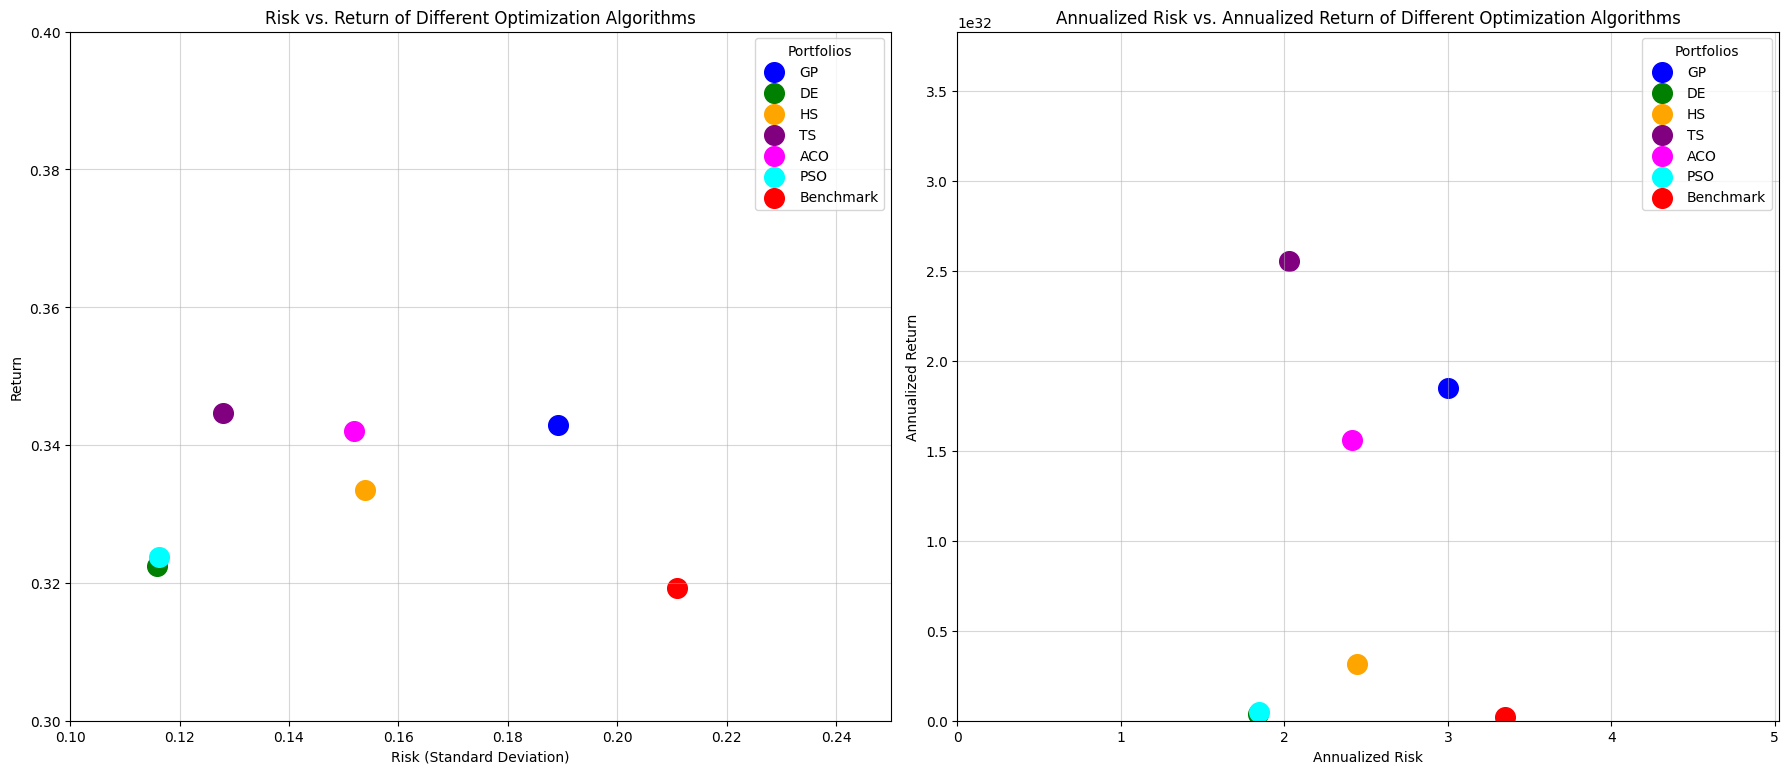

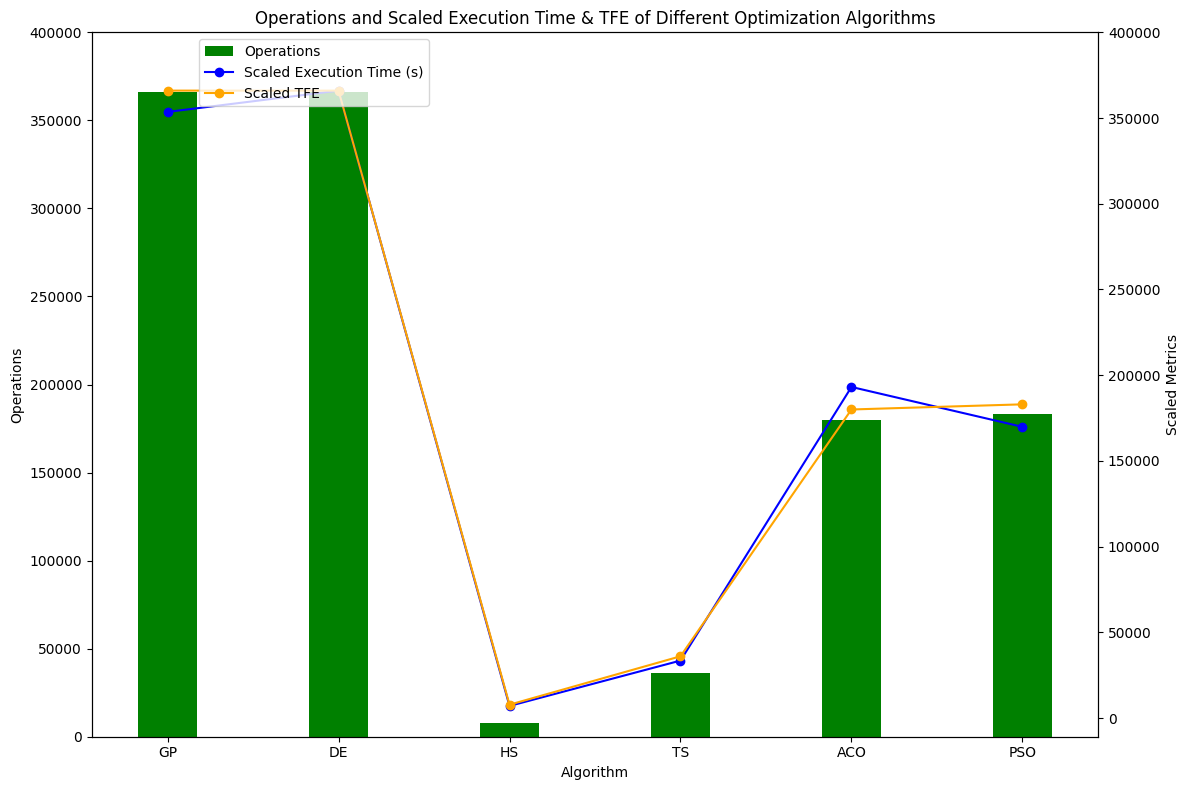

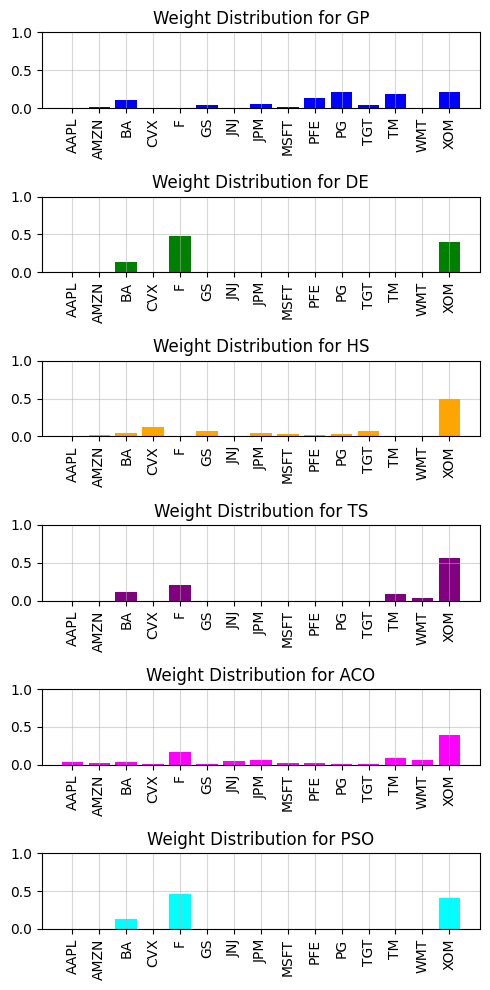

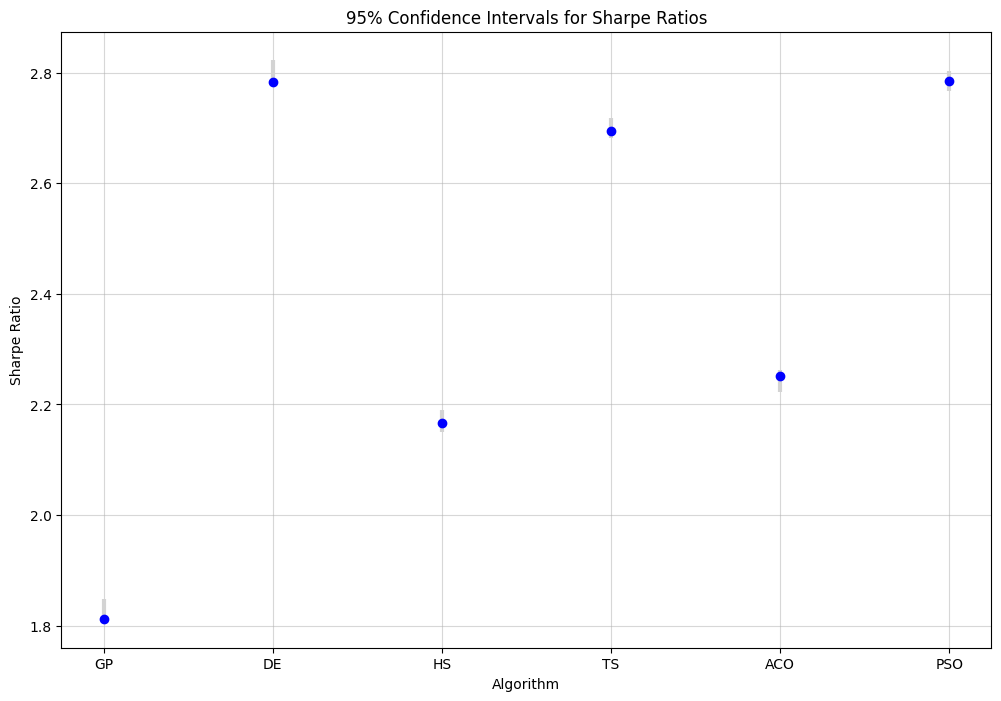

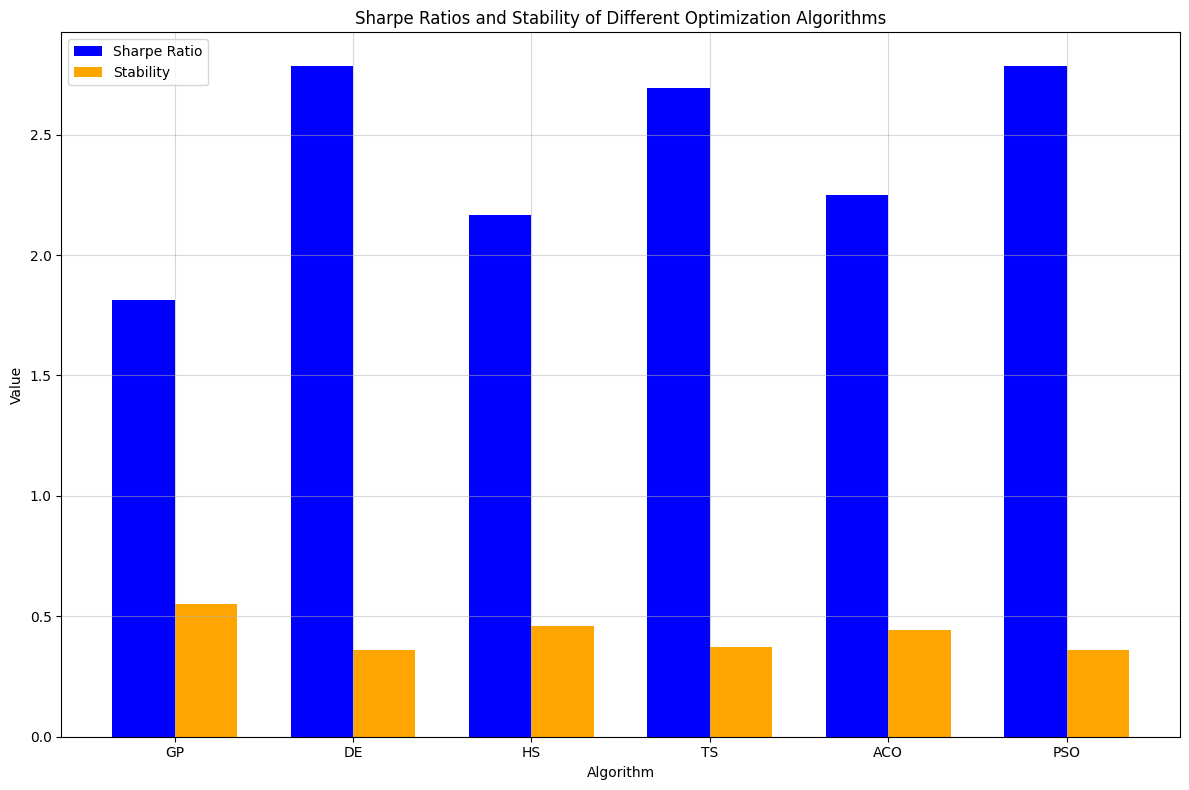

In [7]:
# Define colors for the plots
colors = ['blue', 'green', 'orange', 'purple', 'magenta', 'cyan', 'red']

# Plotting

# Function to adjust grid opacity
def set_grid_opacity(ax, alpha=0.5):
    ax.grid(True, which='both', alpha=alpha)

# Combined Risk/Return and Annualized Risk/Return Plot
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Risk-Return Plot
ax = axs[0]
for i, txt in enumerate(comparison_df['Portfolio']):
    ax.scatter(comparison_df['Risk'][i], comparison_df['Return'][i], c=colors[i], s=200, label=txt)
ax.set_title('Risk vs. Return of Different Optimization Algorithms')
ax.set_xlabel('Risk (Standard Deviation)')
ax.set_ylabel('Return')
ax.legend(title='Portfolios')
set_grid_opacity(ax)
ax.set_xlim(0.1, 0.25)  # Adjusted for better focus
ax.set_ylim(0.3, 0.4)   # Adjusted for better focus

# Annualized Risk-Return Plot
ax = axs[1]
for i, txt in enumerate(comparison_df['Portfolio']):
    ax.scatter(comparison_df['Annualized Risk'][i], comparison_df['Annualized Return'][i], c=colors[i], s=200, label=txt)
ax.set_title('Annualized Risk vs. Annualized Return of Different Optimization Algorithms')
ax.set_xlabel('Annualized Risk')
ax.set_ylabel('Annualized Return')
ax.legend(title='Portfolios')
set_grid_opacity(ax)
ax.set_xlim(0, np.max(comparison_df['Annualized Risk']) * 1.5)  
ax.set_ylim(0, np.max(comparison_df['Annualized Return']) * 1.5)  

plt.tight_layout()
plt.show()

# Combined Plot: Execution Time, TFE, and Operations
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(comparison_df['Portfolio'][:-1]))

# Bar plot for Operations
bar = ax1.bar(index, comparison_df['Operations'][:-1], bar_width, label='Operations', color='green')
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Operations')
ax1.set_title('Operations and Scaled Execution Time & TFE of Different Optimization Algorithms')
ax1.set_xticks(index)
ax1.set_xticklabels(comparison_df['Portfolio'][:-1])

# Create a second y-axis for scaled Execution Time and TFE
ax2 = ax1.twinx()
scaled_execution_time = comparison_df['Execution Time (s)'][:-1] / max(comparison_df['Execution Time (s)'][:-1]) * max(comparison_df['Operations'][:-1])
scaled_tfe = comparison_df['Total Function Evaluations (TFE)'][:-1] / max(comparison_df['Total Function Evaluations (TFE)'][:-1]) * max(comparison_df['Operations'][:-1])
ax2.plot(index, scaled_execution_time, label='Scaled Execution Time (s)', color='blue', marker='o')
ax2.plot(index, scaled_tfe, label='Scaled TFE', color='orange', marker='o')
ax2.set_ylabel('Scaled Metrics')

# Disable the grid for this plot
ax1.grid(False)

# Align the grids of both axes
ax2.set_yticks(ax1.get_yticks())
ax1.set_yticks(ax1.get_yticks())

# Add legends for both y-axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1,1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()

# Weight Distribution Plot
portfolios = ['GP', 'DE', 'HS', 'TS', 'ACO', 'PSO']
plt.figure(figsize=(5, 10))
for i, portfolio in enumerate(portfolios):
    plt.subplot(6, 1, i + 1)
    plt.bar(stock_columns_list, results[portfolio]['Weights'], color=colors[i])
    plt.title(f'Weight Distribution for {portfolio}')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    set_grid_opacity(plt.gca())
plt.tight_layout()
plt.show()

# Calculate confidence intervals for Sharpe ratios
def compute_confidence_intervals(data, confidence=0.95):
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean - h, mean + h

# Dummy replication for CI calculation
def replicate_sharpe_ratios(sharpe_ratio, n=100):
    return np.random.normal(loc=sharpe_ratio, scale=0.1, size=n)

confidence_intervals = {
    portfolio: compute_confidence_intervals(replicate_sharpe_ratios(results[portfolio]['Sharpe Ratio']))
    for portfolio in results if portfolio != 'Benchmark'
}

# Plot Confidence Intervals for Sharpe Ratios
fig, ax = plt.subplots(figsize=(12, 8))
means = [results[portfolio]['Sharpe Ratio'] for portfolio in confidence_intervals.keys()]
ci_intervals = np.array([(means[i] - confidence_intervals[portfolio][0], confidence_intervals[portfolio][1] - means[i]) for i, portfolio in enumerate(confidence_intervals.keys())]).T
portfolios_with_ci = list(confidence_intervals.keys())

# Ensure all error values are positive
ci_intervals = np.abs(ci_intervals)

ax.errorbar(portfolios_with_ci, means, yerr=ci_intervals, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
ax.set_title('95% Confidence Intervals for Sharpe Ratios')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Sharpe Ratio')
set_grid_opacity(ax)
plt.show()

# Plot Sharpe Ratios and Stability
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(comparison_df['Portfolio'][:-1]))

# Bar plot for Sharpe Ratios
bar1 = ax.bar(index - bar_width/2, comparison_df['Sharpe Ratio'][:-1], bar_width, label='Sharpe Ratio', color='blue')
# Bar plot for Stability
bar2 = ax.bar(index + bar_width/2, comparison_df['Stability'][:-1], bar_width, label='Stability', color='orange')

ax.set_xlabel('Algorithm')
ax.set_ylabel('Value')
ax.set_title('Sharpe Ratios and Stability of Different Optimization Algorithms')
ax.set_xticks(index)
ax.set_xticklabels(comparison_df['Portfolio'][:-1])
set_grid_opacity(ax)

# Add legends for both bar charts
ax.legend()

plt.tight_layout()
plt.show()
